<a href="https://colab.research.google.com/github/theerapatxx13/Test/blob/main/FinalMiniProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()  # อัปโหลดไฟล์
filename = list(uploaded.keys())[0]  # ดึงชื่อไฟล์

Saving house_prices.csv to house_prices (2).csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. โหลดไฟล์ CSV เข้าเป็น DataFrame (Import Dataset)
df = pd.read_csv('house_prices.csv')

# 2. Data Cleaning
# ตรวจ Missing Values
missing_values = df.isnull().sum()

# ฟังชันก์นี้ แปลงข้อมูลราคาในคอลัมน์ amount เช่น "45 Lac" → 4,500,000
def clean_amount(x):
    if pd.isna(x): return np.nan
    x = str(x).lower().replace('inr', '').replace(',', '').strip()
    try:
        val = float(re.findall(r"[-+]?\d*\.\d+|\d+", x)[0])
        if 'lac' in x: return val * 100000
        if 'cr' in x: return val * 10000000
        return val
    except: return np.nan

# แปลงคอลัมน์ Area เพราะเก็บค่าพื้นที่เป็น string เช่น "1200 sqft" จะถูกแปลงให้เป็น 1200.0
def clean_area(x):
    if pd.isna(x): return np.nan
    try:
        return float(re.findall(r"[-+]?\d*\.\d+|\d+", str(x))[0])
    except: return np.nan

df['Price_Total'] = df['Amount(in rupees)'].apply(clean_amount)
df['Area'] = df['Carpet Area'].apply(clean_area).fillna(df['Super Area'].apply(clean_area))

# ลบคอลัมน์ที่ไม่ใช้ หรือเป็น text ยาว ไม่ช่วยทำนายราคา
df = df.drop(columns=['Dimensions', 'Plot Area', 'Index', 'Description', 'Title', 'Society', 'Car Parking', 'Ownership', 'overlooking', 'facing'])

# ทำความสะอาด numeric counts
def extract_num(x):
    if pd.isna(x): return 0
    res = re.findall(r"\d+", str(x))
    return int(res[0]) if res else 0

df['Bathroom'] = df['Bathroom'].apply(extract_num)
df['Balcony'] = df['Balcony'].apply(extract_num)

# ลบข้อมูลแถวในคอลัมน์ของ price_total, area ที่เป็น null เพื่อที่จะไปทำนาย
df = df.dropna(subset=['Price_Total', 'Area'])

# เติมค่า Missing ของ categorical ด้วย mode
for col in ['location', 'Status', 'Floor', 'Transaction', 'Furnishing']:
    df[col] = df[col].fillna(df[col].mode()[0])

# จัดการ Outliers (Outlier Detection)
q_p = df['Price_Total'].quantile(0.99)
q_a = df['Area'].quantile(0.99)
df_clean = df[(df['Price_Total'] <= q_p) & (df['Area'] <= q_a)].copy()

print("Missing values Before:\n", missing_values)
print("\nMissing values AFTER cleaning:\n", df_clean.isnull().sum())

#แสดงผลก่อน Outlier
outlier_before = pd.Series({
    'Price': (df['Price_Total'] > q_p).sum(),
    'Area' : (df['Area'] > q_a).sum()
})

print("\nOutliers before:")
print(outlier_before)

#แสดงผลหลัง Outlier
outlier_after = pd.Series({
    'Price': (df_clean['Price_Total'] > q_p).sum(),
    'Area' : (df_clean['Area'] > q_a).sum()
})
print("\nOutliers after:")
print(outlier_after)


Missing values Before:
 Index                     0
Title                     0
Description            3023
Amount(in rupees)         0
Price (in rupees)     17665
location                  0
Carpet Area           80673
Status                  615
Floor                  7077
Transaction              83
Furnishing             2897
facing                70233
overlooking           81436
Society              109678
Bathroom                828
Balcony               48935
Car Parking          103357
Ownership             65517
Super Area           107685
Dimensions           187531
Plot Area            187531
dtype: int64

Missing values AFTER cleaning:
 Amount(in rupees)        0
Price (in rupees)     7540
location                 0
Carpet Area          75616
Status                   0
Floor                    0
Transaction              0
Furnishing               0
Bathroom                 0
Balcony                  0
Super Area           99994
Price_Total              0
Area              

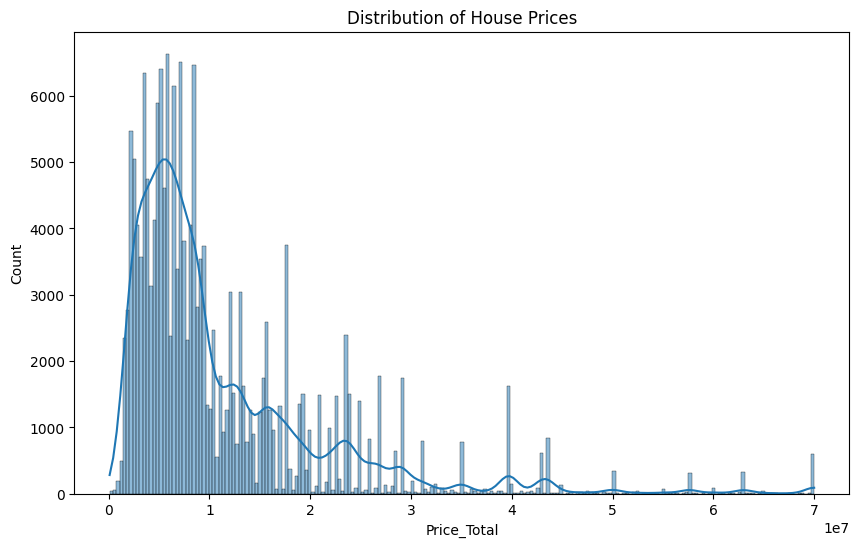

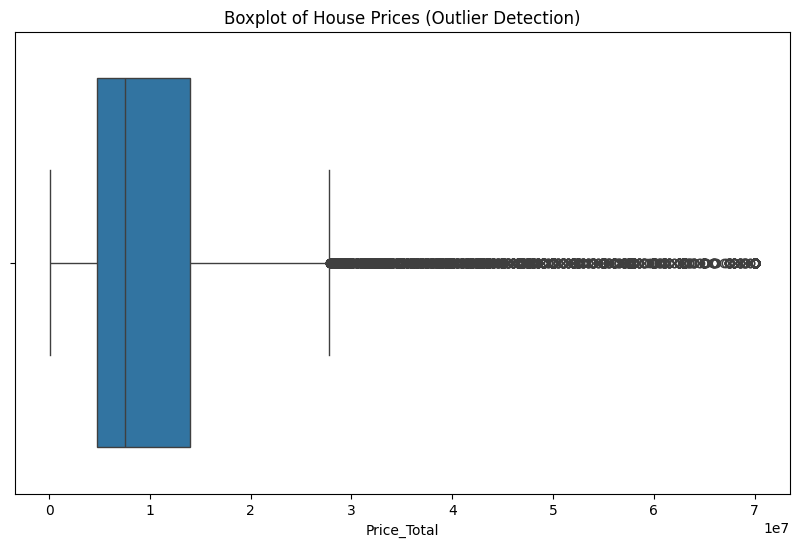

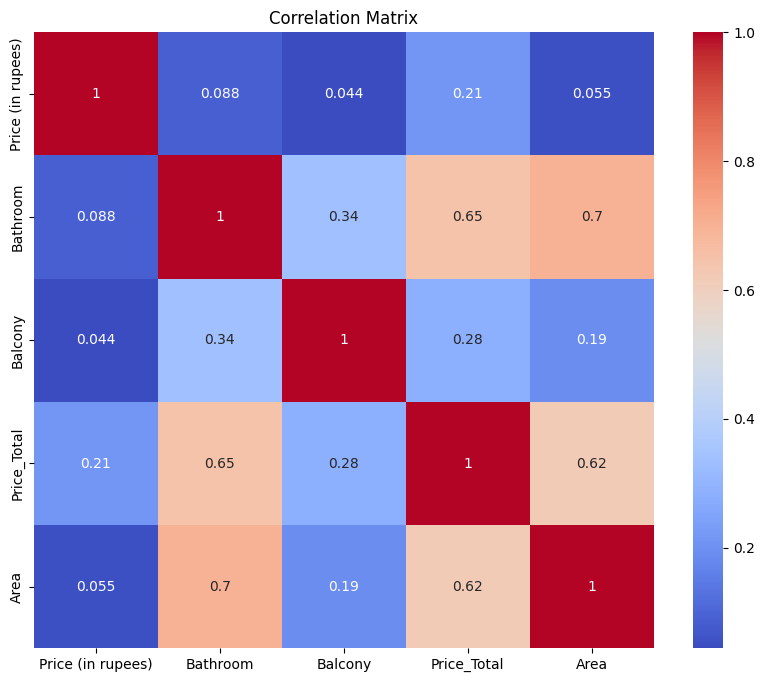

In [ ]:
# 3. EDA
desc_stats = df_clean.describe()

# Plot 1: Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Price_Total'], kde=True)
plt.title('Distribution of House Prices')
plt.savefig('price_dist.png')

# Plot 3: Boxplot for Outlier Detection (Price)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['Price_Total'])
plt.title('Boxplot of House Prices (Outlier Detection)')
plt.savefig('price_outlier_boxplot.png')
plt.show()

# Plot 2: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df_clean.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('corr_matrix.png')

# Preprocessing for Modeling
# แปลง categorical ให้เป็นตัวเลข เพราะโมเดลรับได้แค่ตัวเลข (Label Encoding for categoricals)
le = LabelEncoder()
cat_cols = ['location', 'Status', 'Floor', 'Transaction', 'Furnishing']
for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

In [ ]:
# 4. แยก X, y และกำหนด Train Test Split เป็น 80/20
X = df_clean.drop(columns=['Price_Total', 'Amount(in rupees)', 'Price (in rupees)', 'Carpet Area', 'Super Area'])
y = df_clean['Price_Total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 5. เทรนโมเดล (Training Models)
lr = LinearRegression()
ridge = Ridge(alpha=1.0)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

# ทำนายแต่ละโมเดล (Predictions)
y_pred_lr = lr.predict(X_test)
y_pred_ridge = ridge.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [ ]:
# 6. Evaluation ด้วย Metric R2, MAE, RMSE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

models = {
    "Linear Regression": y_pred_lr,
    "Ridge Regression": y_pred_ridge,
    "Random Forest": y_pred_rf
}

results = []

for name, preds in models.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append([name, r2, mae, rmse])

results_df = pd.DataFrame(results, columns=["Model", "R2", "MAE", "RMSE"])

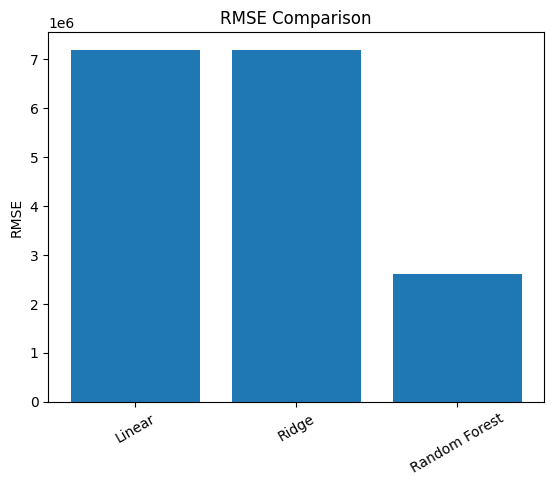

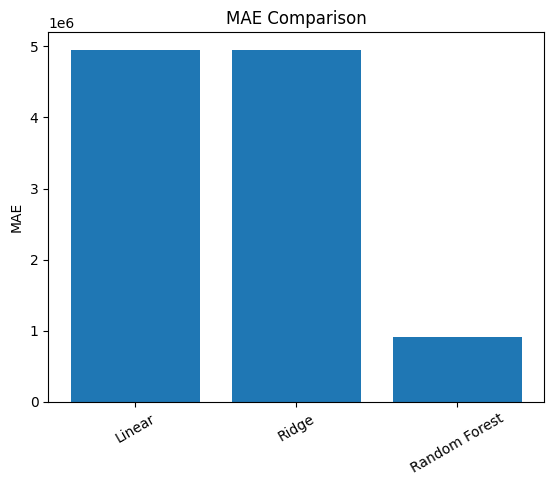

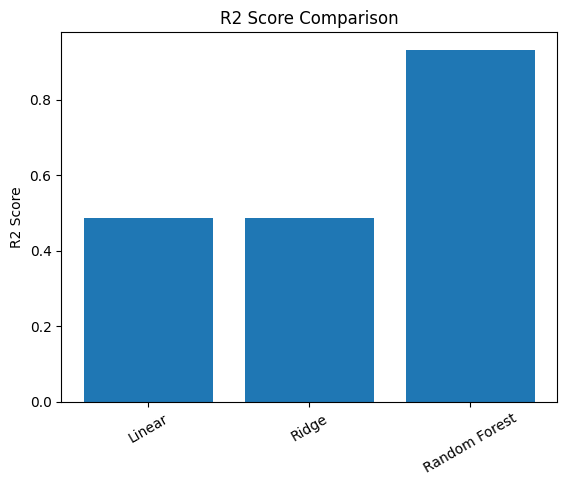

In [ ]:
# 7. เปรียบเทียบผลโมเดล
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

models = ["Linear", "Ridge", "Random Forest"]

#MAE
mae_scores = [
    mean_absolute_error(y_test, y_pred_lr),
    mean_absolute_error(y_test, y_pred_ridge),
    mean_absolute_error(y_test, y_pred_rf)
]

plt.figure()
plt.bar(models, mae_scores)
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.xticks(rotation=30)
plt.show()

#RMSE
rmse_scores = [
    np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    np.sqrt(mean_squared_error(y_test, y_pred_rf))
]

plt.figure()
plt.bar(models, rmse_scores)
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=30)
plt.show()

#R2 Score
r2_scores = [
    r2_score(y_test, y_pred_lr),
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_rf)
]

plt.figure()
plt.bar(models, r2_scores)
plt.title("R2 Score Comparison")
plt.ylabel("R2 Score")
plt.xticks(rotation=30)
plt.show()


In [ ]:
# 8. แสดงผลลัพธ์
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

models = {
    "Linear Regression": y_pred_lr,
    "Ridge Regression": y_pred_ridge,
    "Random Forest": y_pred_rf
}

results = []

for name, preds in models.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append([name, r2, mae, rmse])

results_df = pd.DataFrame(results, columns=["Model", "R2", "MAE", "RMSE"])

print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
               Model        R2           MAE          RMSE
0  Linear Regression  0.487802  4.951600e+06  7.191638e+06
1   Ridge Regression  0.487802  4.951595e+06  7.191638e+06
2      Random Forest  0.932344  9.114506e+05  2.613737e+06


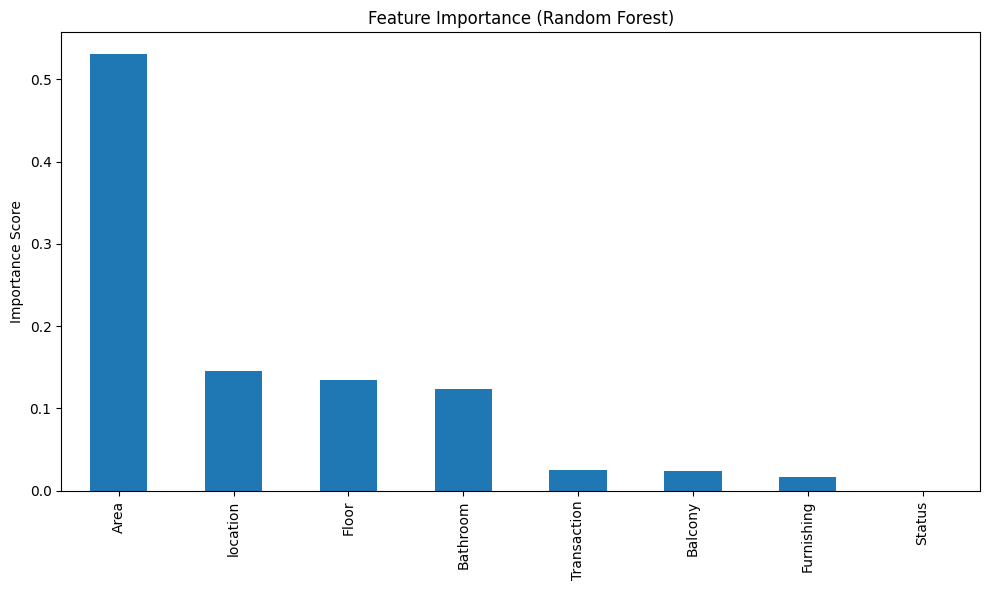

In [ ]:
# 8. ฟีเจอร์ที่สำคัญต่อการทำนาย(Feature Importance)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.ylabel("Importance Score")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()


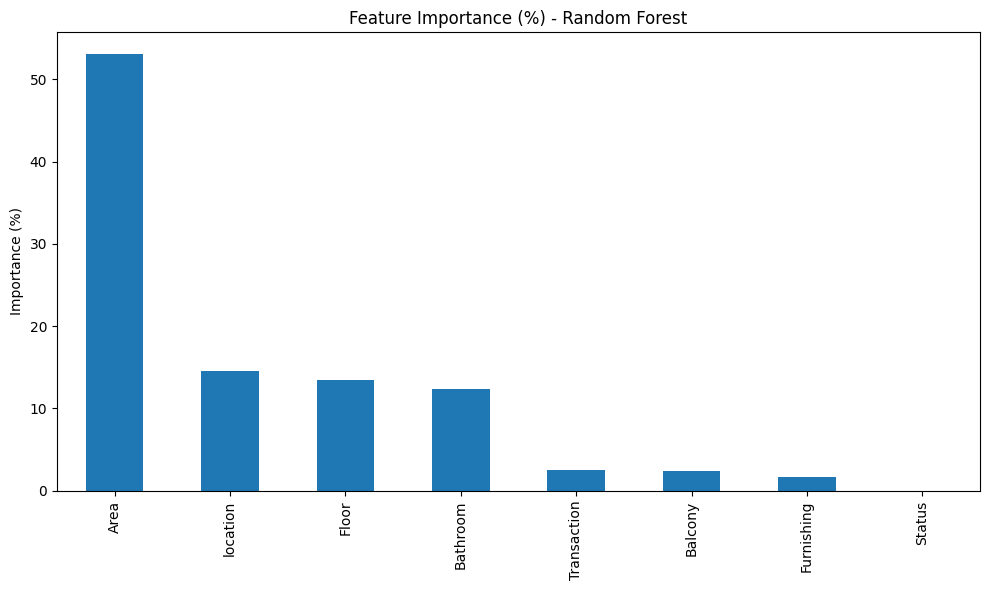


Feature Importance (%)
Area           53.06
location       14.53
Floor          13.49
Bathroom       12.34
Transaction     2.54
Balcony         2.36
Furnishing      1.69
Status          0.00
dtype: float64


In [ ]:
# 7. Feature Importance เปอร์เซ็นต์
importances = rf.feature_importances_
feature_names = X.columns

feat_imp_pct = (
    pd.Series(importances, index=feature_names)
    .sort_values(ascending=False) * 100
)

plt.figure(figsize=(10, 6))
feat_imp_pct.plot(kind='bar')
plt.ylabel('Importance (%)')
plt.title('Feature Importance (%) - Random Forest')
plt.tight_layout()
plt.savefig('feature_importance_percent.png')
plt.show()

print("\nFeature Importance (%)")
print(feat_imp_pct.round(2))